In [1]:
# This simulates Phasecam pupil images
# (original purpose: drawing a cartoon)

# The most important thing to calculate here is the tilt between the two beams at K and H

# created 2019 Mar 15 by E.S.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd
from scipy import ndimage
from astropy.io import fits

%matplotlib inline

In [3]:
lmir_PS = 0.0107 # LMIR plate scale (asec per pixel)
pc_PS = 0.078 # PC plate scale (asec per pixel; Defrere+ 2015)
lambda_K = 2.2e-6 # wavelength of Phasecam (m)
lambda_H = 1.6e-6 # wavelength of Phasecam (m)
c = 3e8 # speed of light (m/s)

In [4]:
# calculate angle due to dispersion

In [1]:
# dispersion relation for ZnSe (Connolly et al. 1979: n 0.54-18.2 µm)
# (as posted on https://refractiveindex.info/?shelf=main&book=ZnSe&page=Connolly)

def n_znse(lambda_um):
    '''
    Index of refraction for Ge
    
    INPUT:
    wavelength (um)
    
    OUTPUT:
    index of ref n
    '''
    
    # read in csv and find n at nearest wavelength
    n_znse_list = pd.read_csv("data/n_znse.csv")
    
    # interpolate
    n = np.interp(lambda_um, n_znse_list["wavel_um"], n_znse_list["n"])
    
    return n

In [2]:
# dispersion relation for Ge (Li 1980: n 1.9-18 µm; 100 K)
# (as posted on https://refractiveindex.info/?shelf=main&book=Ge&page=Li-100K)

def n_ge(lambda_um):
    '''
    Index of refraction for Ge
    
    INPUT:
    wavelength (um)
    
    OUTPUT:
    index of ref n
    '''
    
    # read in csv and find n at nearest wavelength
    n_ge_list = pd.read_csv("data/n_ge.csv")
    
    # interpolate
    n = np.interp(lambda_um, n_ge_list["wavel_um"], n_ge_list["n"])
    
    return n

In [7]:
def snell_theta_t(ni, nt, theta_i):
    '''
    Finds the transmitted angle via Snell's law
    
    INPUTS:
    ni: index of refraction of incident material (ASSUMED CONSTANT HERE)
    nt: index of refraction of transmission material
    theta_i: incident angle (in deg)
    '''
    
    sin_theta_t = np.divide(ni,nt)*np.sin(theta_i*np.pi/180.)
    theta_t = np.arcsin(sin_theta_t)*180./np.pi
    
    return theta_t

In [11]:
# see Buscher+ 2015, sec. 1.4

def illum_PC(lambda_PC, beta_PC, tao12_PC, x_coord_pre_rot, deg_rot=0):
    '''
    Generate a pupil image of fringes
    
    INPUTS:
    lambda_PC: wavelength of Phasecam (m)
    beta_PC: angle of converging beams (deg)
    tao12_PC: phase shift (deg)
    x_coord_pre_rot: x pixel coordinate of image, before any rotation
    deg_rot: degrees to rotate CW
    '''
    
    # argument of the exp part
    arg_exp = np.divide(2*np.pi*1j,lambda_PC)*(2*np.divide(pc_PS*x_coord_pre_rot,206265)*\
                                               np.sin(beta_PC*np.pi/180.) + c*tao12_PC*np.pi/180.)
    
    # illumination before any rotation
    i_x_pre_rot = 1 + np.real(np.exp(arg_exp))
    
    # apply rotation (+ -> CW)
    if (deg_rot != 0):
        i_x_post_rot = scipy.ndimage.rotate(i_x_pre_rot, angle=deg_rot)
        return i_x_post_rot
    else:
        return i_x_pre_rot

In [4]:
# circular mask

def create_circular_mask(image, center=None, radius=None):

    h, w = np.shape(image)
    
    if center is None: # use the middle of the image
        center = [int(w/2), int(h/2)]
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

In [5]:
# initialize a grid

x = np.arange(0, 100)
y = np.arange(0, 100)
xv, yv = np.meshgrid(x, y)

In [6]:
pc_image_K = illum_PC(lambda_PC=lambda_K, 
                beta_PC=45, 
                tao12_PC=0, 
                x_coord_pre_rot=xv,
                deg_rot=10)
mask_circle = create_circular_mask(pc_image_K, radius = 5)
pc_image_K = np.multiply(pc_image_K,mask_circle)

In [10]:
pc_image_H = illum_PC(lambda_PC=lambda_H, 
                beta_PC=45, 
                tao12_PC=0, 
                x_coord_pre_rot=xv,
                deg_rot=10)
mask_circle = create_circular_mask(pc_image_H, radius = 5)
pc_image_H = np.multiply(pc_image_H,mask_circle)

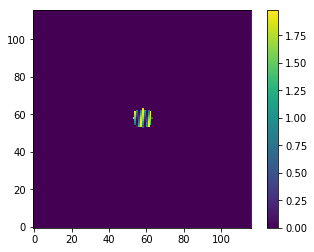

In [13]:
plt.imshow(pc_image_K, origin="lower")
plt.colorbar()
plt.show()

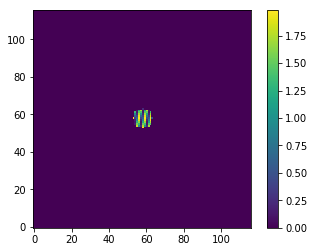

In [14]:
plt.imshow(pc_image_H, origin="lower")
plt.colorbar()
plt.show()

In [15]:
# write FITS

hdu = fits.PrimaryHDU(pc_image_K)
hdul = fits.HDUList([hdu])
hdul.writeto('junk_K.fits', overwrite=True)

In [16]:
# write FITS

hdu = fits.PrimaryHDU(pc_image_H)
hdul = fits.HDUList([hdu])
hdul.writeto('junk_H.fits', overwrite=True)